In [1]:
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
import time
import pandas as pd
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import numpy as np

%matplotlib inline

2025-06-12 21:31:41.827276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749778301.900993    3962 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749778301.922942    3962 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749778302.078676    3962 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749778302.078714    3962 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749778302.078717    3962 computation_placer.cc:177] computation placer alr

In [2]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# List physical devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("🚀 GPU(s) detected!")
    for gpu in gpus:
        print(f" - {gpu}")
    print("TensorFlow will use the GPU by default when available.")
else:
    print("⚠️ No GPU detected. Using CPU only.")

🚀 GPU(s) detected!
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow will use the GPU by default when available.


In [3]:
# Load KMNIST from tensorflow_datasets
(ds_train, ds_test), ds_info = tfds.load(
    'kmnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

I0000 00:00:1749778306.891427    3962 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/paul/Advanced_Deep_Learning_Midterm_Paul/.venv/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [4]:
# Preprocessing function: flatten images and one-hot encode labels
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0         # Normalize to [0,1]
    image = tf.reshape(image, [-1])                    # Flatten to 784
    label = tf.one_hot(label, depth=10)                # One-hot encode
    return image, label

BATCH_SIZE = 256

ds_train = ds_train.map(preprocess).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2025-06-12 21:31:47.365009: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-06-12 21:31:47.768556: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


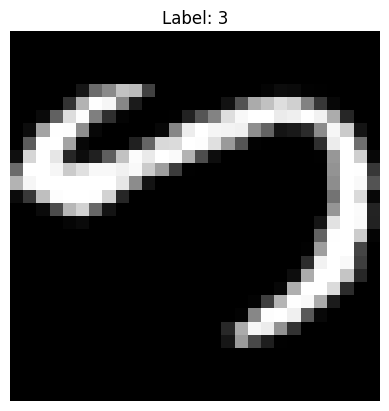

2025-06-12 21:31:48.002259: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Display one sample image from KMNIST (reshaped for visualization)

for image, label in ds_train.take(1):
    img = tf.reshape(image[0], (28, 28))  # Take the first image in the batch and reshape
    plt.imshow(img.numpy(), cmap='gray')
    plt.title(f"Label: {np.argmax(label[0].numpy())}")  # Show the class index
    plt.axis('off')
    plt.show()

In [6]:
# Prepare full dataset as numpy arrays for cross-validation
images = []
labels = []
results = []

for image, label in tfds.as_numpy(ds_train.unbatch()):
    images.append(image.flatten() / 255.0)
    labels.append(label) 
    
X = np.array(images, dtype=np.float32)
y = np.stack(labels).astype(np.float32)

# Learning rate scheduler
def scheduler(epoch, lr):
    return lr / np.sqrt(epoch + 1)

lr_callback = LearningRateScheduler(scheduler)

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"🔁 Fold {fold+1}/5")

    model = Sequential([
        Dense(128, activation='relu', input_shape=(784,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    
    # Optimizer setup
    optimizer = Adam(
        learning_rate=1e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
        )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()
    
    model.fit(
        X[train_index], y[train_index],
        validation_data=(X[val_index], y[val_index]),
        epochs=10,
        batch_size=BATCH_SIZE,
        callbacks=[lr_callback],
        verbose=2
    )
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X[val_index], y[val_index], verbose=0)

    # Store results
    results.append({
        'Fold': fold + 1,
        'Accuracy': val_accuracy,
        'Loss': val_loss,
        'Training Time (s)': elapsed_time
    })

# Create and display table
results_df = pd.DataFrame(results)
print(results_df)

2025-06-12 21:31:58.380875: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/paul/Advanced_Deep_Learning_Midterm_Paul/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🔁 Fold 1/5
Epoch 1/10


2025-06-12 21:31:59.626049: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.
2025-06-12 21:32:00.669133: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


188/188 - 17s - 93ms/step - accuracy: 0.7162 - loss: 0.8868 - val_accuracy: 0.3233 - val_loss: 2.2128 - learning_rate: 1.0000e-03
Epoch 2/10
188/188 - 16s - 85ms/step - accuracy: 0.8220 - loss: 0.5763 - val_accuracy: 0.6108 - val_loss: 1.7669 - learning_rate: 7.0711e-04
Epoch 3/10
188/188 - 15s - 78ms/step - accuracy: 0.8443 - loss: 0.5072 - val_accuracy: 0.8648 - val_loss: 0.7796 - learning_rate: 4.0825e-04
Epoch 4/10
188/188 - 15s - 78ms/step - accuracy: 0.8550 - loss: 0.4731 - val_accuracy: 0.8871 - val_loss: 0.4132 - learning_rate: 2.0412e-04
Epoch 5/10
188/188 - 15s - 81ms/step - accuracy: 0.8589 - loss: 0.4540 - val_accuracy: 0.8938 - val_loss: 0.3500 - learning_rate: 9.1287e-05
Epoch 6/10
188/188 - 15s - 78ms/step - accuracy: 0.8632 - loss: 0.4480 - val_accuracy: 0.8952 - val_loss: 0.3426 - learning_rate: 3.7268e-05
Epoch 7/10
188/188 - 15s - 81ms/step - accuracy: 0.8620 - loss: 0.4444 - val_accuracy: 0.8956 - val_loss: 0.3407 - learning_rate: 1.4086e-05
Epoch 8/10
188/188 - 15s

2025-06-12 21:34:42.617261: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.
2025-06-12 21:34:42.968074: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


188/188 - 16s - 84ms/step - accuracy: 0.7171 - loss: 0.8912 - val_accuracy: 0.2095 - val_loss: 2.2177 - learning_rate: 1.0000e-03
Epoch 2/10
188/188 - 15s - 79ms/step - accuracy: 0.8274 - loss: 0.5584 - val_accuracy: 0.7853 - val_loss: 1.7149 - learning_rate: 7.0711e-04
Epoch 3/10
188/188 - 15s - 81ms/step - accuracy: 0.8481 - loss: 0.4941 - val_accuracy: 0.8802 - val_loss: 0.7187 - learning_rate: 4.0825e-04
Epoch 4/10
188/188 - 15s - 77ms/step - accuracy: 0.8612 - loss: 0.4513 - val_accuracy: 0.8977 - val_loss: 0.3709 - learning_rate: 2.0412e-04
Epoch 5/10
188/188 - 15s - 82ms/step - accuracy: 0.8647 - loss: 0.4373 - val_accuracy: 0.9014 - val_loss: 0.3293 - learning_rate: 9.1287e-05
Epoch 6/10
188/188 - 17s - 89ms/step - accuracy: 0.8647 - loss: 0.4325 - val_accuracy: 0.9040 - val_loss: 0.3247 - learning_rate: 3.7268e-05
Epoch 7/10
188/188 - 17s - 90ms/step - accuracy: 0.8691 - loss: 0.4253 - val_accuracy: 0.9028 - val_loss: 0.3216 - learning_rate: 1.4086e-05
Epoch 8/10
188/188 - 16s

2025-06-12 21:37:26.432875: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


188/188 - 16s - 86ms/step - accuracy: 0.7160 - loss: 0.9038 - val_accuracy: 0.2826 - val_loss: 2.2352 - learning_rate: 1.0000e-03
Epoch 2/10
188/188 - 15s - 82ms/step - accuracy: 0.8179 - loss: 0.5859 - val_accuracy: 0.6013 - val_loss: 1.7958 - learning_rate: 7.0711e-04
Epoch 3/10
188/188 - 16s - 83ms/step - accuracy: 0.8430 - loss: 0.5119 - val_accuracy: 0.8438 - val_loss: 0.7809 - learning_rate: 4.0825e-04
Epoch 4/10
188/188 - 16s - 85ms/step - accuracy: 0.8510 - loss: 0.4798 - val_accuracy: 0.8898 - val_loss: 0.3853 - learning_rate: 2.0412e-04
Epoch 5/10
188/188 - 16s - 85ms/step - accuracy: 0.8558 - loss: 0.4606 - val_accuracy: 0.8975 - val_loss: 0.3412 - learning_rate: 9.1287e-05
Epoch 6/10
188/188 - 15s - 79ms/step - accuracy: 0.8579 - loss: 0.4558 - val_accuracy: 0.8985 - val_loss: 0.3334 - learning_rate: 3.7268e-05
Epoch 7/10
188/188 - 15s - 80ms/step - accuracy: 0.8594 - loss: 0.4528 - val_accuracy: 0.8998 - val_loss: 0.3302 - learning_rate: 1.4086e-05
Epoch 8/10
188/188 - 14s